# 9 拡散モデルの実装

前回は、拡散モデルの理論について学んだ。

拡散モデルでは、U-netと呼ばれるモデルが良く使用されている。本章では、U-netについて説明し、その後に実装を行う。次に、時刻データを効率良く処理するための「正弦波位置エンコーディング」について学ぶ。その後、ガウスノイズを追加する拡散過程を確かめながら実装し、最後にMNISTデータセットを使って拡散モデルの学習を行う。

## 9.1 U-Net

前回述べたように、拡散モデルで使用されるネットワークはノイズを予測する。数式では$\epsilon_\boldsymbol{\theta}(\boldsymbol{x}_t,t)$と表すことができる。

このニューラルネットワークへの入力は、ノイズが追加されたデータ$x_t$と時刻(ノイズを加えた回数）$t$の二つが入力される。ここでは、$t$を省略したニューラルネットワークの実装をする。

入力がノイズが追加されたデータ$\boldsymbol{x}_t$のみの場合、ニューラルネットワークは$\epsilon_\boldsymbol{\theta}(\boldsymbol{x}_t)$と表すことがきでる。このニューラルネットワークは入力と出力の形状が同じである。AutoEncoder, FCN, U-netなどが例に挙げられるが、拡散モデルでは、U-Netがよく用いられる。

### 9.1.1 U-Netとは

U-Netは、セマンティックセグメンテーションのために開発されたモデルである。セマンティックセグメンテーションとは、各ピクセルに対して特定のラベル付けを行うタスクである。医療分野で言うと、CTデータから臓器の判別を行う等に使用される。また自動運転では、人、信号、前方車両を区別するために用いられる。

U-Netへの入力は(C, H, W)の形状の画像データである。ここで、CはRGBの３チャンネルを意味する。H,Wは高さと幅をそれぞれ意味する。出力は(D, H, W)としてD=Cとして、入出力のチャンネル数を同じに設定する。U-netで行う処理は、前半の縮小ステージと拡大ステージに分けられる。縮小を行うステージをダウンサンプリング層、拡大を行う層をアップサンプリング層と呼ばれる。

U-Netの重要な特徴は、スキップ接続です。

### 9.1.2 U-Netの実装

$1\times 28\times 28$ のMNISTを想定した、実装を行う。

ConvBlockクラスを実装する。

In [1]:
import torch
from torch import nn


class ConvBlock(nn.Module):                         # Conv Blockの作成
    def __init__(self, in_ch, out_ch):              # コンストラクタの定義
        super().__init__()
        self.convs = nn.Sequential(                 # nn.sequential を使用して作成
            nn.Conv2d(in_ch, out_ch, 3, padding=1), # Conv を使用
            nn.BatchNorm2d(out_ch),                 # batch正規化
            nn.ReLU(),                              # 活性関数
            nn.Conv2d(out_ch, out_ch, 3, padding=1),# 二層目のconv
            nn.BatchNorm2d(out_ch),                 # batch正規化
            nn.ReLU()                               # 活性関数
        )

    def forward(self, x):
        return self.convs(x)                        # convsの中身をこれ一度で作用させることがきる。

In [2]:
class UNet(nn.Module):                          # U-Netクラスを実装
    def __init__(self, in_ch=1):                # コンストラクタの実装
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)       # ConvBlockを使用し作成
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)      # 畳み込み演算

        self.maxpool = nn.MaxPool2d(2)          # maxpooling の計算
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear') # upsamplingの初期化

    def forward(self, x):
        x1 = self.down1(x)            # Conv block
        x = self.maxpool(x1)          # 縮小を行う
        x2 = self.down2(x)            # Conv block
        x = self.maxpool(x2)          # 縮小

        x = self.bot1(x)              # Conv block 

        x = self.upsample(x)          # バイリニア補完による拡大
        x = torch.cat([x, x2], dim=1) # 接続
        x = self.up2(x)               # Conv block
        x = self.upsample(x)          # upsampleを使った拡大
        x = torch.cat([x, x1], dim=1) # 接続
        x = self.up1(x)               # Conv block
        x = self.out(x)               # 畳み込み
        return x

実際に実行すると次のようになる。

In [3]:
model = UNet()
x = torch.randn(10, 1, 28, 28)  # dummy input
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


foward 部分の各処理における形状を確認する。

In [4]:
x1 = model.down1(x)
print("down1(x)           ",x1.shape)
x = model.maxpool(x1)
print("maxpool(x1)        ",x.shape)
x2 = model.down2(x)           
print("down2(x)           ",x2.shape)
x = model.maxpool(x2)         
print("maxpool(x2)        ",x.shape)
x = model.bot1(x)              
print("bot1(x)            ",x.shape)
x = model.upsample(x)         
print("upsample(x)        ",x.shape)
x = torch.cat([x, x2], dim=1)
print("cat([x, x2], dim=1)",x.shape)
x = model.up2(x)              
print("up2(x)             ",x.shape)
x = model.upsample(x)         
print("upsample(x)        ",x.shape)
x = torch.cat([x, x1], dim=1)
print("cat([x, x1], dim=1)",x.shape)
x = model.up1(x)              
print("up1(x)             ",x.shape)
x = model.out(x)              
print("out(x)             ",x.shape)

down1(x)            torch.Size([10, 64, 28, 28])
maxpool(x1)         torch.Size([10, 64, 14, 14])
down2(x)            torch.Size([10, 128, 14, 14])
maxpool(x2)         torch.Size([10, 128, 7, 7])
bot1(x)             torch.Size([10, 256, 7, 7])
upsample(x)         torch.Size([10, 256, 14, 14])
cat([x, x2], dim=1) torch.Size([10, 384, 14, 14])
up2(x)              torch.Size([10, 128, 14, 14])
upsample(x)         torch.Size([10, 128, 28, 28])
cat([x, x1], dim=1) torch.Size([10, 192, 28, 28])
up1(x)              torch.Size([10, 64, 28, 28])
out(x)              torch.Size([10, 1, 28, 28])


これで、一旦時刻を含まないUNetが完成した。次に、時刻を入力として与えるように拡張していく。

## 9.2 正弦波位置エンコーディング

前節では、$x_t$を処理するU-Netを実装した。ここで、時刻$t$は整数である。拡散モデルでは、時刻$t$のエンコーディングにおいて**正弦波位置エンコーディング**が使用される。

### 9.2.1 正弦波位置エンコーディングとは

正弦波位置エンコーディングは「Attention is All You Need」のTransformerで使用されたことで、有名になった。

位置情報とは、系列データの各要素の出現位置のことである。正弦波位置エンコーディングは、整数$t$をベクトル$\boldsymbol{v}$へ変換する。変換後のベクトル$\boldsymbol{v}$の次元数を$D$とすると、その$i$番目の要素は次の式で表される。

$$\boldsymbol{v}_i = \left\{ \begin{array}{ll} \sin(\frac{t}{10000^{\frac{i}{D}}}) & i\%2 = 0 \\ \cos(\frac{t}{10000^{\frac{i}{D}}}) & i\%2 = 1 \end{array} \right.$$

位置情報の相対的な差異や周期的なパターンが明確に表現でき、モデルは系列データの中の相対一の関係性をより効果的に学習できる。

一応、どのようなデータが出るかを確認する。

In [5]:
def pos_encord(t,D = 100):
    lis = []
    for i in range(D):
        theta = t / ((10000)**(i/D))
        if t % 2 == 0:
            lis.append(np.sin(theta))
        else:
            lis.append(np.cos(theta))
    return lis

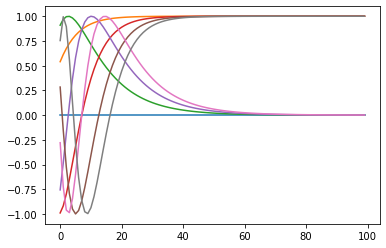

In [6]:
import numpy as np
import matplotlib.pyplot as plt

lis = []

for t in range(8):
    v = pos_encord(t)
    plt.plot(v,label = str(t))

plt.show()

### 9.2.2 正弦波位置エンコーディングの実装 

正弦波位置エンコーディングの実装を行う。

はじめに、一つのデータをエンコードする関数_pos_encoding()を実装する。次に、バッチデータを処理する関数pos_encoding()と言う名前で実装する。

In [7]:
import torch
import math

def _pos_encoding(time_idx, output_dim, device='cpu'):
    t, D = time_idx, output_dim
    v = torch.zeros(D, device=device)

    i = torch.arange(0, D, device=device)             # [0,1...,D-1]の行列を作る
    div_term = torch.exp(i / D * math.log(10000))

    v[0::2] = torch.sin(t / div_term[0::2])           # スライス法:０から始まり、1飛ばしの全ての要素を指定(偶数)
    v[1::2] = torch.cos(t / div_term[1::2])           # 上と同様に1から始まり、1鳥羽市の全ての要素を指定(奇数)
    return v

In [8]:
v = _pos_encoding(1, 16)
print(v.shape)

torch.Size([16])


次にバッチデータを処理する正弦波位置エンコーディングの実装を行う。ここでは、わかりやすさを優先して、for文を利用して次のように実装する。

In [9]:
def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)                                # timestepsはテンソルを意味する
    device = timesteps.device
    v = torch.zeros(batch_size, output_dim, device=device)     # バッチ分を格納するためのもの
    for i in range(batch_size):
        v[i] = _pos_encoding(timesteps[i], output_dim, device) # 先ほど作成した関数を用いる
    return v

In [10]:
v = pos_encoding(torch.tensor([1, 2, 3]), 16)
print(v.shape)

torch.Size([3, 16])


### 9.2.3 U-Netに組み込む

U-Netに正弦波位置エンコーディングを組み込む。ConvBlockクラスに正弦波位置エンコーディングを取り入れる。

そのために、新しいConvBlockを導入する。

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim): # コンストラクタ
        super().__init__()
        self.convs = nn.Sequential(                    # convs
            nn.Conv2d(in_ch, out_ch, 3, padding=1),    # 畳み込み
            nn.BatchNorm2d(out_ch),                    # バッチ正規化
            nn.ReLU(),                                 # 活性化関数
            nn.Conv2d(out_ch, out_ch, 3, padding=1),   # 畳み込み
            nn.BatchNorm2d(out_ch),                    # バッチ正規化
            nn.ReLU()                                  # 活性化関数
        )
        self.mlp = nn.Sequential(                      # mlp
            nn.Linear(time_embed_dim, in_ch),          # 線型変換
            nn.ReLU(),                                 # 非線形変換
            nn.Linear(in_ch, in_ch)                    # 線形変換
        )

    def forward(self, x, v):
        N, C, _, _ = x.shape                           # shapeの一部を使用
        v = self.mlp(v)                                # positional encodeing
        v = v.view(N, C, 1, 1)                         # 形状の変更
        y = self.convs(x + v)                          # 畳み込みにencodeingの情報を加える
        return y

上記ConvBlockを用いたUNetを作成する。

In [12]:
class UNet(nn.Module):                                             # UNetの実装を行う      
    def __init__(self, in_ch=1, time_embed_dim=100):         
        super().__init__()
        self.time_embed_dim = time_embed_dim                       # 各層を定義

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)      
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1  = ConvBlock(128, 256, time_embed_dim)
        self.up2   = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1   = ConvBlock(128 + 64, 64, time_embed_dim)
        self.out   = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, timesteps):                                # forward関数
        v  = pos_encoding(timesteps, self.time_embed_dim, x.device) # 前回と同じ

        x1 = self.down1(x, v)
        x  = self.maxpool(x1)
        x2 = self.down2(x, v)
        x  = self.maxpool(x2)

        x  = self.bot1(x, v)

        x  = self.upsample(x)
        x  = torch.cat([x, x2], dim=1)
        x  = self.up2(x, v)
        x  = self.upsample(x)
        x  = torch.cat([x, x1], dim=1)
        x  = self.up1(x, v)
        x  = self.out(x)
        return x

拡散モデルで使用するニューラルネットワークの実装はこれで完成です。

## 9.3 拡散過程

次に、拡散過程の実装を行う。

まずは、$q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$の実装から始めます。

### 9.3.1 $q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$からのサンプリング

拡散モデル$q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$は次の式で表される。

$$ q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1}) = \mathcal{N}(\boldsymbol{x}_t;\sqrt{1-\beta_t}\boldsymbol{x}_{t-1},\beta_t\boldsymbol{I})$$

$q(\boldsymbol{x}_t|\boldsymbol{t-1})$からのサンプリングは変数変換トリックを用いて

$$ \epsilon\sim\mathcal{N}(\boldsymbol{0},\boldsymbol{I})\\
\boldsymbol{x}_t = \sqrt{1-\beta_t}\boldsymbol{x}_{t-1}+\sqrt{\beta_t}\epsilon$$

ダミーデータを使って、上式を実装する。

In [13]:
x = torch.randn(3, 64, 64)
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)                             # xと同じ形状のガウスノイズ
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps


In [14]:
print(x.shape)

torch.Size([3, 64, 64])


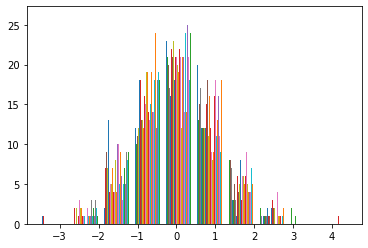

In [15]:
plt.hist(x[0,0:64,:])
plt.show()

分布を見ると、ガウスノイズであることが確認できる。

### 9.3.2 画像に対する拡散過程

続いて、実際の画像データに対して拡散過程の実装を行う。

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# current_dir = os.path.dirname(os.path.abspath(__file__))
file_path = os.path.join('flower.png')
image = plt.imread(file_path)
print(image.shape,type(image))

preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

(64, 64, 3) <class 'numpy.ndarray'>
torch.Size([3, 64, 64])


はじめに、画像の入力について行う。

入力する画像はそのままでは、使用することができない。ndarrayからtensorに変換することで、NeuralNetに作用させることがある。

ToTensorでは、ndarrayやPILをtensorに変換する。また、さらに次の変換も行う。

* 画像のピクセル値の範囲を[0:255]から[0.0:1.0]にスケーリングする
* 画像の次元を(H, W, C)から(C, H, W)に変換する

この二つの操作を行う。

実際に画像を出力する際にはこれと逆の操作を行う。

In [17]:
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)
print(reverse_to_img(x), type(reverse_to_img(x)))

<PIL.Image.Image image mode=RGB size=64x64 at 0x7FCCE5E41430> <class 'PIL.Image.Image'>


tensorからPIL形式に変換されていることがわかる。

それでは、画像データに対して、拡散過程を行う。

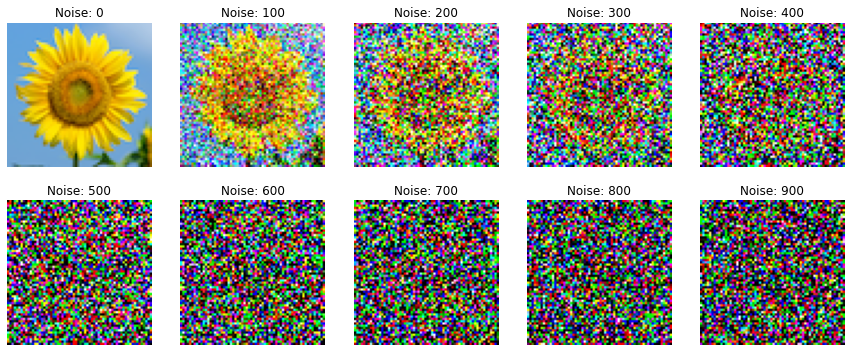

In [18]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)                           # 画像に変換
        imgs.append(img)                                  # imgsにPIL形式を追加

    beta = betas[t]                                       # 時刻tにおけるbetaを取得
    eps = torch.randn_like(x)                             # xと同じ形状のガウス分布を生成
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps # 元画像を1-beta倍してbeta倍したノイズを加算

# show imgs
plt.figure(figsize=(15, 6))
for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()


徐々にノイズが追加され、最終的には完全なノイズになっているように感じる。

### 9.3.3 $q(\boldsymbol{x}_t|\boldsymbol{x}_0)$からのサンプリング

続いて、$q(\boldsymbol{x}_t|\boldsymbol{x}_0)$からのサンプリング処理を実装する。これは、次のとおり解析的に表すことができる。

* ハイパーパラメータの関係式
$$ \alpha_t = 1-\beta_t$$
$$ \bar{\alpha}_t = \alpha_t\alpha_{t-1}\cdots\alpha_1$$

* 確率分布:$q(\boldsymbol{x}_t|\boldsymbol{x}_0)$

$$q(\boldsymbol{x}_t|\boldsymbol{x}_0) = \mathcal{N}(\boldsymbol{x}_t;\sqrt{\bar{\alpha}_t}\boldsymbol{x}_0,(1-\bar{\alpha}_t)\boldsymbol{I})$$

* $q(\boldsymbol{x}_t|\boldsymbol{x}_0)$からのサンプリング

$$\epsilon\sim\mathcal{N}(\boldsymbol{N},\boldsymbol{I})\\
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t}\boldsymbol{x}_0+\sqrt{1-\bar{\alpha}_t}\epsilon$$

ここでは、$\bar{\alpha}_t=\alpha_t\alpha_{t-1}\cdots\alpha_1$を計算する必要がある。これは、torch.comprod()を使用することで計算することができる。

In [19]:
import torch

x = torch.tensor([1, 2, 3, 4])
output = torch.cumprod(x, dim=0)
print(output)

tensor([ 1,  2,  6, 24])


出力の結果はそれぞれの要素までの積になっていることがわかる。

これを利用して、$q(\boldsymbol{x}_t|\boldsymbol{x}_0)$からのサンプリングを実装する。

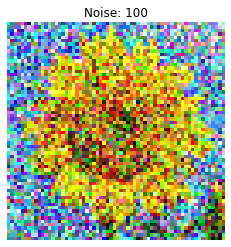

In [20]:
file_path = os.path.join('flower.png')
img = plt.imread(file_path)
x = preprocess(img)

T = 1000
beta_start = 0.0001
beat_end   = 0.02
betas = torch.linspace(beta_start, beta_end, T)

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T                     # 引数tが1以上T以下であるかを確認
    t_idx = t - 1                                # tのインデックスを作成

    alphas = 1 - betas                           
    alpha_bars = torch.cumprod(alphas, dim=0)    # alphaの行列においてt以前の要素の積を計算
    alpha_bar = alpha_bars[t_idx]                # 時刻tにおけるalphaを格納

    eps = torch.randn_like(x_0)                  # x_0と同じ形状のガウス分布を作成
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps # x_tに乱数を加える
    return x_t

t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_img(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

これにより、ループを使用せずに100番目のノイズが加えられたデータを作成することができた。

### 9.3.4 Diffuserクラスの実装

最後に、ここで実装した拡散過程のコードをクラスにまとめる。

クラス名はDiffuserクラスとする。

* **GPUへの対応**:設定に応じてCPUもしくはGPU上で動作させる
* **バッチデータ**:データの形状は(C, H, W)ではなく(N, C, H, W)のデータを扱う

コードは次のとおりである

In [21]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()                    # 1<t and t<Tの確認

        t_idx = t - 1                                               # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]                          # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)                      # (N, 1, 1, 1)に変形

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise


## 9.4 データ生成

データ生成を行うためのメソッドをDiffuserクラスに実装する。

拡散モデルのデータ生成は次のアルゴリズムで表される。


1. $\boldsymbol{x}_T\sim\mathcal{N}(\boldsymbol{0},\boldsymbol{I})$
2. for $t$ in $[T,\cdots,1]$:
3.    $\epsilon\sim\mathcal{N}(\boldsymbol{0},\boldsymbol{I})$
4.    if $t=1$ then $\epsilon=0$
5.    $\sigma_q(t) = \sqrt{\frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})} {1-\bar{\alpha}_t}}$
6.    $\boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \boldsymbol{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon_\boldsymbol{\theta}(\boldsymbol{x}_t, t) \right)+\sigma_q(t)\epsilon$
7. return $\boldsymbol{x}_0$

これを、Diffusionクラスに組み込む


### 9.4.1 ワンステップのデノイズ処理

上記のforループ中の処理を行うメソッドを実装する。メソッド名はdenoise(self, model, x, t)である。xの形状は（N, C, H, W)であり、tは(N,)とする。

In [22]:
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()                    # 1<t and t<Tの確認

        t_idx = t - 1                                               # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]                          # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)                      # (N, 1, 1, 1)に変形

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise
    
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()                                                 # モデルを評価モードへ変更する
        with torch.no_grad():                                        # バックプロパゲーションが不要な場合に使用し、メモリ使用量を削減できる
            eps = model(x, t)
        model.train()                                                # モデルを学習モードへ変更

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0                                            # t=１の場合にTrue,それ以外はFalseとなる。

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

### 9.4.2 データ生成の実装

拡散モデルによって画像を生成するメソッドを実装する。

sample(self, model, x_shape=(20, 1, 28, 28))として実装する。

In [23]:
from tqdm import tqdm

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()                    # 1<t and t<Tの確認

        t_idx = t - 1                                               # alpha_bars[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx]                          # (N,)
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)                      # (N, 1, 1, 1)に変形

        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise
    
    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1  # alphas[0] is for t=1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx-1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
        return mu + noise * std

    def reverse_to_img(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)

    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):                            # 逆順のイテレータを作理、プログレスバーを作成
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t)                                           # denoiseメソッドをfor文中で繰り返し呼び出す

        images = [self.reverse_to_img(x[i]) for i in range(batch_size)]             # tensorからPIL形式に変更
        return images

### 9.5 拡散モデルの学習

importとハイパーパラメータの設定のコードを示す。

In [24]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm


img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def show_images(images, rows=2, cols=10):
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            i += 1
    plt.show()
    

deviceは、gpu, cpuを設定することができ、show_imagesは生成した画像を表示するために用いる。

In [25]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', download=True, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

データセット、データローダを準備する。した。DiffuserとUNetクラス、オプティマイザを次に用意する。

In [26]:

losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    # generate samples every epoch ===================
    # images = diffuser.sample(model)
    # show_images(images)
    # ================================================

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise, noise_pred)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch} | Loss: {loss_avg}')

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# generate samples
images = diffuser.sample(model)
show_images(images)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [19:05<00:00,  2.44s/it]


Epoch 0 | Loss: 0.050074852419210905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [17:09<00:00,  2.19s/it]


Epoch 1 | Loss: 0.02780755115613373


 69%|████████████████████████████████████████████████████████████████████▍                              | 324/469 [11:29<05:08,  2.13s/it]


KeyboardInterrupt: 

### 9.5.2 学習結果

学習結果を見るとlossが徐々に減少していることがわかる。